Q. Does user's demographic(location, age, gender) impact type of anime(genre, episodes, anime type(OVA, movie), Rank) they are prefer?
For solving this question, I am trying to determine the rating of an anime based on user's demographic(Age, Location, Gender) and anime's features(genre, type and episodes)

The second algorithm I am trying here is CatBoostRegressor, this models excels with datasets which have a lot of string data. 
For this model we don't need to individually 1 hot encode or transform our string data. The model has inbuilt capabilities to handle them. We just mention the columns which has string data.

This time instead of classifying to get the expected rating, I am using regression for guess the expected user rating.
Reference: https://catboost.ai/en/docs/

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

data = pd.read_csv('../../joined_datasets/joined_rating_dataset.csv')
cleaned_dataset = pd.read_csv("../../cleaned_datasets/users_details_dataset_cleaned.csv")
data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5207686 entries, 0 to 5207685
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   user_id           int64  
 2   anime_id          int64  
 3   rating            int64  
 4   Gender            object 
 5   Location          object 
 6   Birthday_Date     object 
 7   Joined_Date       object 
 8   Age_Join          float64
 9   Episodes Watched  float64
 10  Age               float64
 11  Name              object 
 12  Genres            object 
 13  Type              object 
 14  Start Date        object 
 15  End Date          object 
 16  Studios           object 
 17  Source            object 
 18  Rank              object 
 19  Episodes          float64
 20  Episodes_Norm     float64
dtypes: float64(5), int64(4), object(12)
memory usage: 834.4+ MB


Performing undersampling as number of rows was a bit too high to compute using my laptop(~50,00,000). Considering only the top 10 countries

In [121]:
df = cleaned_dataset.copy()
import pandas as pd
import matplotlib.pyplot as plt

location_user_counts = df['Location'].value_counts()

top_countries = df['Location'].value_counts().head(10)

# # Get the list of top 20 countries
top_10_countries = top_countries.index.tolist()
data = data[data['Location'].isin(top_10_countries)]
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3357313 entries, 0 to 5207685
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   user_id           int64  
 2   anime_id          int64  
 3   rating            int64  
 4   Gender            object 
 5   Location          object 
 6   Birthday_Date     object 
 7   Joined_Date       object 
 8   Age_Join          float64
 9   Episodes Watched  float64
 10  Age               float64
 11  Name              object 
 12  Genres            object 
 13  Type              object 
 14  Start Date        object 
 15  End Date          object 
 16  Studios           object 
 17  Source            object 
 18  Rank              object 
 19  Episodes          float64
 20  Episodes_Norm     float64
dtypes: float64(5), int64(4), object(12)
memory usage: 563.5+ MB


In [122]:
# Undersampling
# Count entries for each location
location_counts = data['Location'].value_counts()

# Decide the target sample size (e.g., use the minimum count of the top 5 locations)
target_sample_size = location_counts.nsmallest(5).min()  # Choose the minimum of the top 5

# Under-sample the DataFrame
under_sampled_df = data.groupby('Location').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)

# Count occurrences of each class in the target variable (assuming your target variable is 'rating')
target_counts = under_sampled_df['Location'].value_counts()
# Output the results
print("Under-sampled DataFrame shape:", under_sampled_df.shape)
print("Counts of each class in the target variable:")
print(target_counts)

/var/folders/dz/fg9tl53x4y16ytgmdhwdt0kr0000gn/T/ipykernel_15870/807053095.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  under_sampled_df = data.groupby('Location').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)


Under-sampled DataFrame shape: (1075590, 21)
Counts of each class in the target variable:
Location
Australia        107559
Brazil           107559
Canada           107559
France           107559
Germany          107559
Philippines      107559
Poland           107559
Russia           107559
Sweden           107559
United States    107559
Name: count, dtype: int64


Here we are not performing any preprocessing of string data columns, we just mention the column indices while doing model fitting.
Performing first pass for regression using CatBoostRegressor

In [123]:
import catboost as cb
features = under_sampled_df.columns.difference(['user_id', 'anime_id', 'rating', 'Birthday_Date', 'Joined_Date', 'Age_Join', 'Episodes Watched',
                                  'Start Date', 'End Date', 'Name', 'Studios', 'Source', 'Episodes_Norm', 'Unnamed: 0', 'Type'])

df = under_sampled_df.dropna()
df = df[df["Rank"]!="UNKNOWN"]
df[features].info()
print(features)
X = df[features]

y = df["rating"]


# # Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = cb.CatBoostRegressor(
    learning_rate=0.1,
    depth=10,
    iterations=1000,
    loss_function='RMSE'
)

model.fit(X_train, y_train, cat_features=[2,3,4])

<class 'pandas.core.frame.DataFrame'>
Index: 781615 entries, 0 to 1075589
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Age       781615 non-null  float64
 1   Episodes  781615 non-null  float64
 2   Gender    781615 non-null  object 
 3   Genres    781615 non-null  object 
 4   Location  781615 non-null  object 
 5   Rank      781615 non-null  object 
dtypes: float64(2), object(4)
memory usage: 41.7+ MB
Index(['Age', 'Episodes', 'Gender', 'Genres', 'Location', 'Rank'], dtype='object')
0:	learn: 1.6200493	total: 76.6ms	remaining: 1m 16s
1:	learn: 1.5983237	total: 140ms	remaining: 1m 9s
2:	learn: 1.5807286	total: 205ms	remaining: 1m 8s
3:	learn: 1.5656122	total: 280ms	remaining: 1m 9s
4:	learn: 1.5532923	total: 343ms	remaining: 1m 8s
5:	learn: 1.5427331	total: 407ms	remaining: 1m 7s
6:	learn: 1.5340006	total: 475ms	remaining: 1m 7s
7:	learn: 1.5268498	total: 543ms	remaining: 1m 7s
8:	learn: 1.5208395	total: 599ms	rem

Saving the model and testing it

In [124]:
import pickle
!touch ./models/cat_boost_1_model.pkl
# Save the model to a file
with open('./models/cat_boost_1_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('./models/cat_boost_1_model.pkl', 'rb') as file:
    _model = pickle.load(file)
    y_pred = _model.predict(X_test)

To find the efficiency of our regression model, we are using multiple metrics like Mean Square Error, Mean Absolute Error and Root Mean Square Error. The regression worked pretty well, we only have a mean absolute error of 1.12 and root mean square error of 1.46

In [125]:
# To calculate R-squared, you can use the built-in function in libraries like scikit-learn:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# acc = accuracy_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 2.1594679122061073
RMSE: 1.4695128145770309
MAE: 1.1293489312917373


A plot of the spread of predicted rating vs actual rating

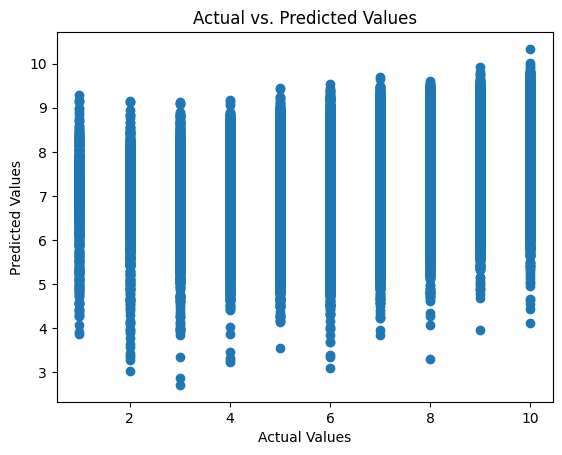

In [126]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()


We also have the ability to check the importance of various features with our model. It appears Episodes did not have much importance compared to other features.

In [127]:
train_pool = cb.Pool(X_train, y_train, cat_features=[2,3,4])
test_pool = cb.Pool(X_test, y_test, cat_features=[2,3,4])
# Get feature importance
feature_importance = model.feature_importances_

# Get SHAP values
shap_values = model.get_feature_importance(data=test_pool, type='ShapValues')

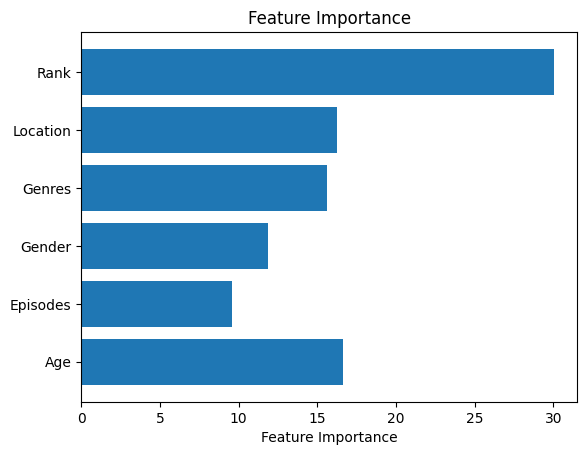

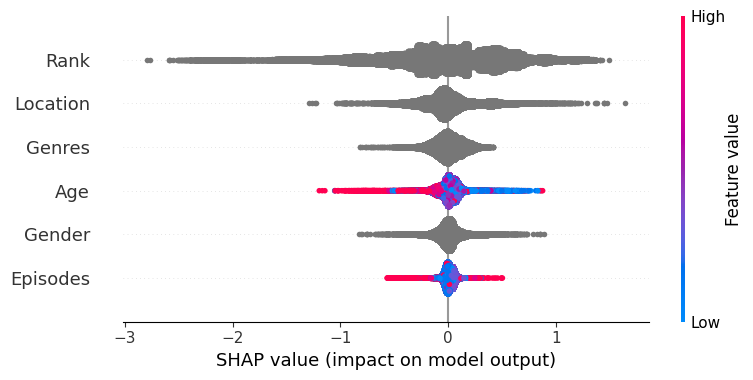

In [128]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), X.columns)
plt.xlabel('Feature Importance')

plt.title('Feature Importance')
plt.show()

# Visualize SHAP values (more advanced)
import shap

shap.summary_plot(shap_values[:,:-1], X_test)

Trying our model without Episodes feature, to see the difference.

In [129]:
import catboost as cb
features = under_sampled_df.columns.difference(['user_id', 'anime_id', 'rating', 'Birthday_Date', 'Joined_Date', 'Age_Join', 'Episodes Watched',
                                  'Start Date', 'End Date', 'Name', 'Studios', 'Source', 'Episodes_Norm', 'Unnamed: 0', 'Type', 'Episodes'])

df = under_sampled_df.dropna()
df = df[df["Rank"]!="UNKNOWN"]
df[features].info()
print(features)
X = df[features]

y = df["rating"]


# # Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = cb.CatBoostRegressor(
    learning_rate=0.1,
    depth=10,
    iterations=1000,
    loss_function='RMSE'
)

model.fit(X_train, y_train, cat_features=[1,2,3])

<class 'pandas.core.frame.DataFrame'>
Index: 781615 entries, 0 to 1075589
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Age       781615 non-null  float64
 1   Gender    781615 non-null  object 
 2   Genres    781615 non-null  object 
 3   Location  781615 non-null  object 
 4   Rank      781615 non-null  object 
dtypes: float64(1), object(4)
memory usage: 35.8+ MB
Index(['Age', 'Gender', 'Genres', 'Location', 'Rank'], dtype='object')
0:	learn: 1.6199767	total: 68.5ms	remaining: 1m 8s
1:	learn: 1.5984787	total: 131ms	remaining: 1m 5s
2:	learn: 1.5805107	total: 197ms	remaining: 1m 5s
3:	learn: 1.5657924	total: 259ms	remaining: 1m 4s
4:	learn: 1.5533246	total: 327ms	remaining: 1m 5s
5:	learn: 1.5430564	total: 390ms	remaining: 1m 4s
6:	learn: 1.5348370	total: 446ms	remaining: 1m 3s
7:	learn: 1.5276711	total: 511ms	remaining: 1m 3s
8:	learn: 1.5215884	total: 576ms	remaining: 1m 3s
9:	learn: 1.5166121	total: 640ms	remain

In [130]:
import pickle
!touch ./models/cat_boost_2_model.pkl
# Save the model to a file
with open('./models/cat_boost_2_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('./models/cat_boost_2_model.pkl', 'rb') as file:
    _model = pickle.load(file)
    y_pred = _model.predict(X_test)


As expected most of the results are unaffected and get the most of the same accuracy without Episodes as well.

In [131]:
# To calculate R-squared, you can use the built-in function in libraries like scikit-learn:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# acc = accuracy_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 2.163443076269243
RMSE: 1.4708647375844057
MAE: 1.13080959630595


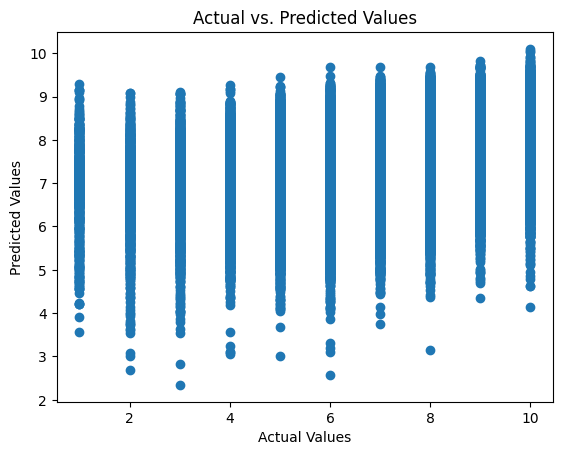

In [132]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()


In [133]:
train_pool = cb.Pool(X_train, y_train, cat_features=[1,2,3])
test_pool = cb.Pool(X_test, y_test, cat_features=[1, 2,3])
# Get feature importance
feature_importance = model.feature_importances_

# Get SHAP values
shap_values = model.get_feature_importance(data=test_pool, type='ShapValues')

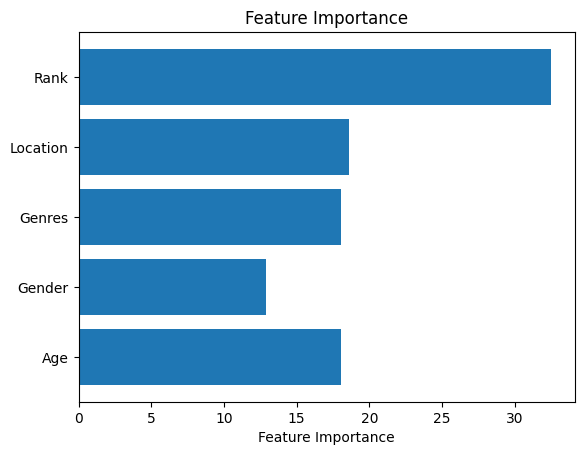

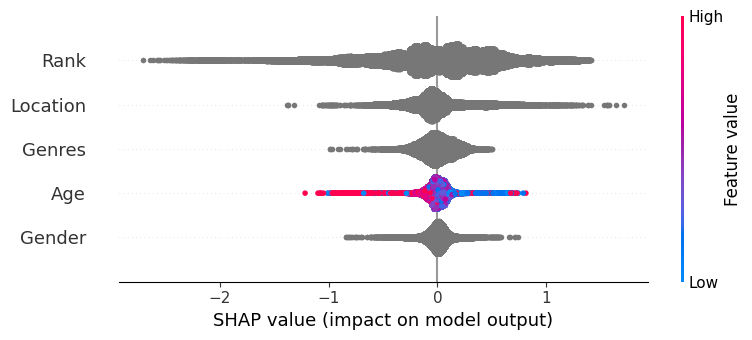

In [134]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), X.columns)
plt.xlabel('Feature Importance')

plt.title('Feature Importance')
plt.show()

# Visualize SHAP values (more advanced)
import shap

shap.summary_plot(shap_values[:,:-1], X_test)

Trying our model with an additional feature of Rank: This is the overal ranking of an anime. This could probably add some more accuracy.
Undersampled the dataset based on rating as well.

In [135]:
import catboost as cb
# Undersampling
# Count entries for each location
rating_counts = under_sampled_df['rating'].value_counts()

target_sample_size = rating_counts.nlargest(7).min()

under_sampled_df = data.groupby('rating').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)

target_counts = under_sampled_df['rating'].value_counts()

# Output the results
print("Under-sampled DataFrame shape:", under_sampled_df.shape)
print("Counts of each class in the target variable:")
print(target_counts)


Under-sampled DataFrame shape: (237172, 21)
Counts of each class in the target variable:
rating
3     25777
4     25777
5     25777
6     25777
7     25777
8     25777
9     25777
10    25777
2     18417
1     12539
Name: count, dtype: int64


/var/folders/dz/fg9tl53x4y16ytgmdhwdt0kr0000gn/T/ipykernel_15870/1426502436.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  under_sampled_df = data.groupby('rating').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)


In [143]:
features = under_sampled_df.columns.difference(['user_id', 'anime_id', 'rating', 'Birthday_Date', 'Joined_Date', 'Age_Join', 'Episodes Watched',
                                  'Start Date', 'End Date', 'Name', 'Studios', 'Source', 'Unnamed: 0', 'Type', 'Episodes', 'Episodes_Norm'])

df = under_sampled_df.dropna()
df = df[df["Rank"]!="UNKNOWN"]
df[features].info()
print(features)
X = df[features]

y = df["rating"]


# # Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = cb.CatBoostRegressor(
    learning_rate=0.1,
    depth=10,
    iterations=1000,
    loss_function='RMSE'
)

model.fit(X_train, y_train, cat_features=[1,2,3])

<class 'pandas.core.frame.DataFrame'>
Index: 166889 entries, 1 to 237171
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Age       166889 non-null  float64
 1   Gender    166889 non-null  object 
 2   Genres    166889 non-null  object 
 3   Location  166889 non-null  object 
 4   Rank      166889 non-null  object 
dtypes: float64(1), object(4)
memory usage: 7.6+ MB
Index(['Age', 'Gender', 'Genres', 'Location', 'Rank'], dtype='object')
0:	learn: 2.6530803	total: 39.7ms	remaining: 39.7s
1:	learn: 2.6071629	total: 77.9ms	remaining: 38.9s
2:	learn: 2.5695120	total: 106ms	remaining: 35.4s
3:	learn: 2.5382725	total: 131ms	remaining: 32.6s
4:	learn: 2.5115207	total: 162ms	remaining: 32.1s
5:	learn: 2.4894424	total: 185ms	remaining: 30.6s
6:	learn: 2.4711166	total: 213ms	remaining: 30.2s
7:	learn: 2.4571892	total: 235ms	remaining: 29.1s
8:	learn: 2.4446709	total: 259ms	remaining: 28.5s
9:	learn: 2.4339762	total: 327ms	remaini

In [144]:
import pickle
!touch ./models/cat_boost_3_model.pkl
# Save the model to a file
with open('./models/cat_boost_3_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('./models/cat_boost_3_model.pkl', 'rb') as file:
    _model = pickle.load(file)
    y_pred = _model.predict(X_test)

The performance was a bit worse after undersampling again.

In [145]:
# To calculate R-squared, you can use the built-in function in libraries like scikit-learn:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# acc = accuracy_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 5.431816917899729
RMSE: 2.330625863990128
MAE: 1.8957902658730832


But with feature importance it can be seen that the importance of ranking is a lot more than all others. 

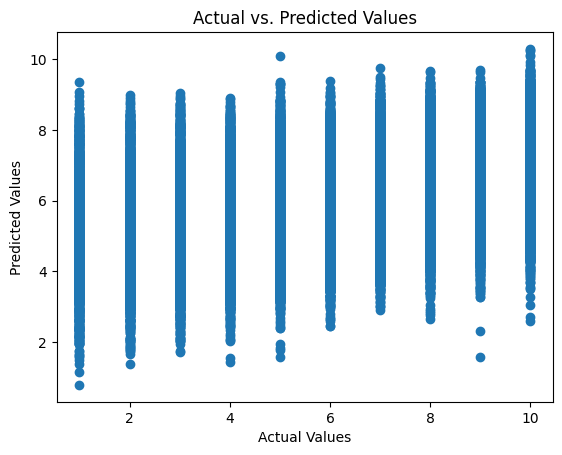

In [146]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()


In [147]:
train_pool = cb.Pool(X_train, y_train, cat_features=[1,2,3])
test_pool = cb.Pool(X_test, y_test, cat_features=[1,2,3])
# Get feature importance
feature_importance = model.feature_importances_

# Get SHAP values
shap_values = model.get_feature_importance(data=test_pool, type='ShapValues')

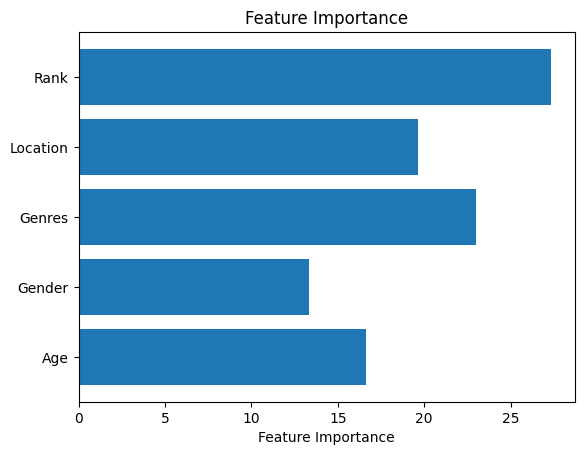

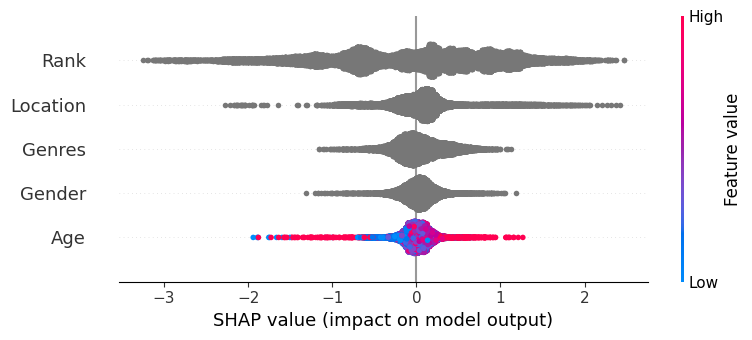

In [148]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), X.columns)
plt.xlabel('Feature Importance')

plt.title('Feature Importance')
plt.show()

# Visualize SHAP values (more advanced)
import shap

shap.summary_plot(shap_values[:,:-1], X_test)